# Fine Tune Transformer from HuggingFace DistilBert (batchsize8)

In [ ]:
pip install transformers[torch] -U

In [ ]:
# %pip install transformers
%pip install torch
%pip install imblearn
%pip install wandb --upgrade


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback, set_seed

# Progress bar
from tqdm._tqdm_notebook import tqdm_notebook
from tqdm import tqdm
tqdm_notebook.pandas()

<ipython-input-6-5c70c929f42e>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


## Import Clean Data

In [ ]:
###############################################################
# Note: Change the name of data set used for feature creation
###############################################################
data_set='bully_data_clean_with_stopword'


###################
# Import Data Set #
###################
bully_data_cleaned = pd.read_csv('/content/drive/MyDrive/fyp/amica_data_clean_with_stopword_short.csv', encoding='utf8')
bully_data_cleaned = bully_data_cleaned[~bully_data_cleaned['text_check'].isna()]
bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['text_check'] != ""]
#bully_data_cleaned = bully_data_cleaned[bully_data_cleaned['role']!='None']
bully_data_cleaned = bully_data_cleaned[['label','text_check']]
bully_data_cleaned['label'] = bully_data_cleaned['label'].progress_apply(lambda x: 1 if x =="Cyberbullying" else 0)
bully_data_cleaned.rename(columns = {'text_check':'text'}, inplace = True)
bully_data_cleaned = bully_data_cleaned.reset_index(drop=True)

  0%|          | 0/112247 [00:00<?, ?it/s]

In [ ]:
bully_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112247 entries, 0 to 112246
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   112247 non-null  int64 
 1   text    112247 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [ ]:
bully_data_cleaned['label'].value_counts()

label
0    106872
1      5375
Name: count, dtype: int64

## Define pretrained tokenizer and model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
set_seed(1127)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preprocess data and Fine Tune Transformers

In [ ]:
# Data: Text Input and Label #
X = list(bully_data_cleaned["text"])
y = list(bully_data_cleaned["label"])

# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall_cb = recall_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    precision_cb = precision_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)
    f1_cb = f1_score(y_true=labels, y_pred=pred, average='binary', pos_label=1)

    recall_ncb = recall_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    precision_ncb = precision_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)
    f1_ncb = f1_score(y_true=labels, y_pred=pred, average='binary', pos_label=0)

    recall_overall = recall_score(y_true=labels, y_pred=pred, average='macro')
    precision_overall = precision_score(y_true=labels, y_pred=pred, average='macro')
    f1_overall = f1_score(y_true=labels, y_pred=pred, average='macro')


    return {"accuracy": accuracy,
            "precision_cb": precision_cb, "recall_cb": recall_cb, "f1_cb": f1_cb,
            "precision_ncb": precision_ncb, "recall_ncb": recall_ncb, "f1_ncb": f1_ncb,
            "precision_overall": precision_overall, "recall_overall": recall_overall, "f1_overall": f1_overall}


# Plot Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''


    # CONFUSION MATRIX IN PERCENTAGE
    cf_pct = cf.astype('float')/cf.sum(axis=1)[:, np.newaxis]
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf_pct.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf_pct,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

# Run cross-validation
def run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y,
                         splits=5,
                         epoch=8,
                         checkpoint=False):

    kfold = StratifiedShuffleSplit(n_splits=splits, test_size=0.1, random_state=1127)
    # kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=1127)
    n_fold = 1

    print("Developing Model with Cross validation for: " + model_name)
    for train, test in tqdm(kfold.split(X, y)):

        print("Running for Fold: ",n_fold)
        train_index = list(train)
        test_index = list(test)

        X_train = [X[i] for i in train_index]
        y_train = [y[i] for i in train_index]
        X_val = [X[i] for i in test_index]
        y_val = [y[i] for i in test_index]

        # Tokenize
        X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
        X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

        # Create torch dataset
        train_dataset = Dataset(X_train_tokenized, y_train)
        val_dataset = Dataset(X_val_tokenized, y_val)

        # Fine Tune Transformer
        # Define Trainer
        args = TrainingArguments(
            output_dir="content/drive/MyDrive_binary/output_" + model_name + "/fold"+str(n_fold),
            evaluation_strategy="epoch",
            save_strategy="epoch",
            #eval_steps=500,
            #per_device_train_batch_size=1,
            #per_device_eval_batch_size=1,
            num_train_epochs=epoch, #1 was okay
            seed=1127,
            load_best_model_at_end=True,
        )

        trainer = Trainer(
        #model_init=model_init,
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        )

        if n_fold <=4:
            checkpoint_temp=True
        else:
            checkpoint_temp=False

        trainer.train(resume_from_checkpoint=checkpoint)
        print("Complete for fold", n_fold)
        n_fold= n_fold + 1


# Run Hold Out Test

# Train and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1127)

# Train and Validate Set
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=1127)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_test)

def run_hold_out_split(model_name='DistilBert',
                       epoch=8,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False):

    print("Developing Model with Hold Out Splits for: " + model_name)
    # Fine Tune Transformer
    # Define Trainer
    args = TrainingArguments(
      output_dir="content/drive/MyDrive_binary/output_" + model_name + "/holdout",
      evaluation_strategy="epoch",
      save_strategy="epoch",
      #eval_steps=500,
      #per_device_train_batch_size=1,
      #per_device_eval_batch_size=1,
      num_train_epochs=epoch, #1 was okay
      seed=1127,
      load_best_model_at_end=True,
    )

    trainer = Trainer(
    # model_init=model_init,
    args=args,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
    )

    trainer.train(resume_from_checkpoint=checkpoint)
    print("Complete for hold-out validate set")


In [ ]:
# Predict (Hold Out Test)

from sklearn.metrics import confusion_matrix
def compute_metrics_holdout(model_name='DistilBert',
                            model_path='content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-3820',
                            average_method='binary',
                            X_test=X_test):

    X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

    # Create torch dataset
    test_dataset = Dataset(X_test_tokenized)

    # Load trained model
    model_pred = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)

    # Define test trainer
    test_trainer = Trainer(model_pred)

    # Make prediction
    raw_pred, _, _ = test_trainer.predict(test_dataset)

    # Preprocess raw predictions
    y_pred = np.argmax(raw_pred, axis=1)

    # Compute metrics
    precision_cb = precision_score(y_test, y_pred, average=average_method, pos_label=1)
    recall_cb = recall_score(y_test, y_pred, average=average_method, pos_label=1)
    f1_cb = f1_score(y_test, y_pred, average=average_method, pos_label=1)

    precision_ncb = precision_score(y_test, y_pred, average=average_method, pos_label=0)
    recall_ncb = recall_score(y_test, y_pred, average=average_method, pos_label=0)
    f1_ncb = f1_score(y_test, y_pred, average=average_method, pos_label=0)

    precision_overall = precision_score(y_test, y_pred, average='macro')
    recall_overall = recall_score(y_test, y_pred, average='macro')
    f1_overall = f1_score(y_test, y_pred, average='macro')

    # Print Results
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print()
    print("Label 1: Cyberbullying")
    print("Precision: ", precision_cb)
    print("Recall: ", recall_cb)
    print("F-measure: ", f1_cb)
    print()
    print("Label 0: Non-Cyberbullying")
    print("Precision: ", precision_ncb)
    print("Recall: ", recall_ncb)
    print("F-measure: ", f1_ncb)
    print()
    print("Macro Metrics")
    print("Precision: ", precision_overall)
    print("Recall: ", recall_overall)
    print("F-measure: ", f1_overall)
    print()

    # Confusion Matrix
    conf_mat = confusion_matrix(y_test,y_pred)
    categories = ['Non-Cyberbullying', 'Cyberbullying']
    labels = ['True Negative','',
            '','True Positive']

    make_confusion_matrix(conf_mat,
                        group_names=labels,
                        categories=categories,
                        figsize=(8,5),
                        cbar=True,
                        title='Fine Tuned ' + model_name + ' for Cyberbullying Detection',
                        cmap='YlGnBu',
                        sum_stats=False)



## Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y,
                         splits=5,
                         epoch=4,
                         checkpoint=False)

Developing Model with Cross validation for: DistilBert


0it [00:00, ?it/s]

Running for Fold:  1


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.156700,0.168656,0.962851,0.682779,0.420074,0.520138,0.971360,0.990175,0.980677,0.827070,0.705125,0.750408
2,0.108700,0.117097,0.964989,0.687339,0.494424,0.575135,0.974903,0.988678,0.981742,0.831121,0.741551,0.778439
3,0.111600,0.140398,0.965434,0.714286,0.464684,0.563063,0.973517,0.990643,0.982005,0.843901,0.727663,0.772534
4,0.109400,0.143993,0.965612,0.714689,0.470260,0.567265,0.973783,0.990549,0.982095,0.844236,0.730405,0.774680


1it [1:27:39, 5259.06s/it]

Complete for fold 1
Running for Fold:  2


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.128700,0.145762,0.959020,0.564356,0.635688,0.597902,0.981543,0.975297,0.978410,0.772949,0.805492,0.788156
2,0.134200,0.147849,0.966058,0.754045,0.433086,0.550177,0.972059,0.992889,0.982364,0.863052,0.712987,0.766270
3,0.104700,0.136967,0.967840,0.697987,0.579926,0.633503,0.979031,0.987368,0.983182,0.838509,0.783647,0.808342
4,0.102700,0.132017,0.967751,0.717822,0.539033,0.615711,0.977082,0.989333,0.983169,0.847452,0.764183,0.799440


2it [2:55:48, 5277.17s/it]

Complete for fold 2
Running for Fold:  3


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.135700,0.136752,0.959376,0.565079,0.661710,0.609589,0.982822,0.974361,0.978573,0.773951,0.818036,0.794081
2,0.139100,0.137555,0.960535,0.580372,0.637546,0.607617,0.981663,0.976794,0.979222,0.781017,0.807170,0.793420
3,0.122900,0.110417,0.969265,0.714922,0.596654,0.650456,0.979863,0.988023,0.983926,0.847392,0.792339,0.817191
4,0.095100,0.116712,0.971136,0.754762,0.589219,0.661795,0.979547,0.990362,0.984925,0.867154,0.789791,0.823360


3it [4:24:20, 5293.02s/it]

Complete for fold 3
Running for Fold:  4


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.152400,0.154040,0.964900,0.714286,0.446097,0.549199,0.972633,0.991017,0.981739,0.843459,0.718557,0.765469
2,0.160900,0.146358,0.968196,0.738786,0.520446,0.610687,0.976212,0.990736,0.983421,0.857499,0.755591,0.797054
3,0.131800,0.133819,0.970601,0.785714,0.531599,0.634146,0.976798,0.992701,0.984685,0.881256,0.762150,0.809416
4,0.110600,0.126872,0.971581,0.765133,0.587361,0.664564,0.979467,0.990924,0.985162,0.872300,0.789142,0.824863


4it [5:52:55, 5301.70s/it]

Complete for fold 4
Running for Fold:  5


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.153200,0.175669,0.967929,0.750000,0.496283,0.597315,0.975067,0.991672,0.983299,0.862533,0.743977,0.790307


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.153200,0.175669,0.967929,0.750000,0.496283,0.597315,0.975067,0.991672,0.983299,0.862533,0.743977,0.790307
2,0.105300,0.140938,0.968731,0.769452,0.496283,0.603390,0.975087,0.992514,0.983724,0.872270,0.744398,0.793557
3,0.088500,0.146924,0.968820,0.783133,0.483271,0.597701,0.974479,0.993263,0.983781,0.878806,0.738267,0.790741
4,0.079200,0.142383,0.969265,0.738272,0.555762,0.634146,0.977911,0.990081,0.983959,0.858091,0.772922,0.809053


5it [7:21:32, 5298.43s/it]

Complete for fold 5


### [Continue] Cross Validation (K = 5)

In [ ]:
run_cross_validation(model_name='DistilBert',
                         X=X,
                         y=y,
                         splits=5,
                         epoch=4,
                         checkpoint=True)

Developing Model with Cross validation for: DistilBert


0it [00:00, ?it/s]

Running for Fold:  1


Epoch,Training Loss,Validation Loss


1it [00:30, 30.41s/it]

Complete for fold 1
Running for Fold:  2


Epoch,Training Loss,Validation Loss


2it [01:04, 32.31s/it]

Complete for fold 2
Running for Fold:  3


Epoch,Training Loss,Validation Loss


3it [01:24, 26.67s/it]

Complete for fold 3
Running for Fold:  4


Epoch,Training Loss,Validation Loss


4it [01:43, 24.03s/it]

Complete for fold 4
Running for Fold:  5


Epoch,Training Loss,Validation Loss


5it [02:03, 24.77s/it]

Complete for fold 5


## Hold Out Split

In [ ]:
#holdout
run_hold_out_split(model_name='DistilBert',
                       epoch=4,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=False)

Developing Model with Hold Out Splits for: DistilBert


Epoch,Training Loss,Validation Loss,Accuracy,Precision Cb,Recall Cb,F1 Cb,Precision Ncb,Recall Ncb,F1 Ncb,Precision Overall,Recall Overall,F1 Overall
1,0.121100,0.153068,0.970780,0.716942,0.644981,0.679061,0.982218,0.987181,0.984693,0.849580,0.816081,0.831877
2,0.094800,0.103272,0.971581,0.765133,0.587361,0.664564,0.979467,0.990924,0.985162,0.872300,0.789142,0.824863
3,0.105100,0.151155,0.970067,0.737089,0.583643,0.651452,0.979257,0.989520,0.984362,0.858173,0.786582,0.817907
4,0.098900,0.145850,0.970690,0.741339,0.596654,0.661174,0.979893,0.989520,0.984683,0.860616,0.793087,0.822928


Complete for hold-out validate set


In [ ]:
#holdout
run_hold_out_split(model_name='DistilBert',
                       epoch=4,
                       train_dataset=train_dataset,
                       eval_dataset=val_dataset,
                       checkpoint=True)

Developing Model with Hold Out Splits for: DistilBert


Epoch,Training Loss,Validation Loss


Complete for hold-out validate set


### Test Split Confusion Matrix

#### Epoch 1


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10687
           1       0.72      0.64      0.68       538

    accuracy                           0.97     11225
   macro avg       0.85      0.82      0.83     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7169421487603306
Recall:  0.6449814126394052
F-measure:  0.6790606653620352

Label 0: Non-Cyberbullying
Precision:  0.9822176706079508
Recall:  0.9871806868157574
F-measure:  0.9846929251446704

Macro Metrics
Precision:  0.8495799096841408
Recall:  0.8160810497275813
F-measure:  0.8318767952533528



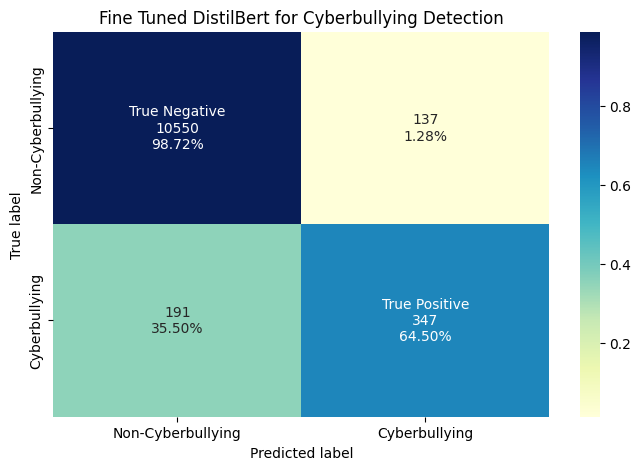

In [ ]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='/content/content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-12628',
                        average_method='binary',
                        X_test=X_test)

#### Epoch 2

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10687
           1       0.77      0.59      0.66       538

    accuracy                           0.97     11225
   macro avg       0.87      0.79      0.82     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7651331719128329
Recall:  0.587360594795539
F-measure:  0.6645636172450053

Label 0: Non-Cyberbullying
Precision:  0.9794672586015538
Recall:  0.9909235519790399
F-measure:  0.9851621005628168

Macro Metrics
Precision:  0.8723002152571934
Recall:  0.7891420733872895
F-measure:  0.8248628589039111



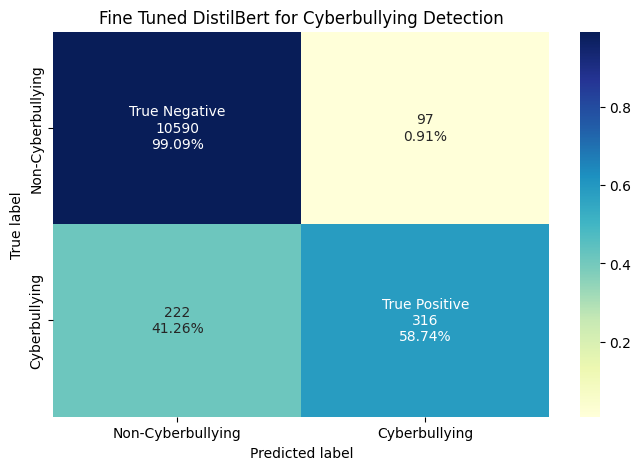

In [ ]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='/content/content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-25256',
                        average_method='binary',
                        X_test=X_test)

#### Epoch 3

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10687
           1       0.74      0.58      0.65       538

    accuracy                           0.97     11225
   macro avg       0.86      0.79      0.82     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7370892018779343
Recall:  0.5836431226765799
F-measure:  0.6514522821576764

Label 0: Non-Cyberbullying
Precision:  0.9792573386424669
Recall:  0.9895199775428091
F-measure:  0.984361910080983

Macro Metrics
Precision:  0.8581732702602005
Recall:  0.7865815501096944
F-measure:  0.8179070961193297



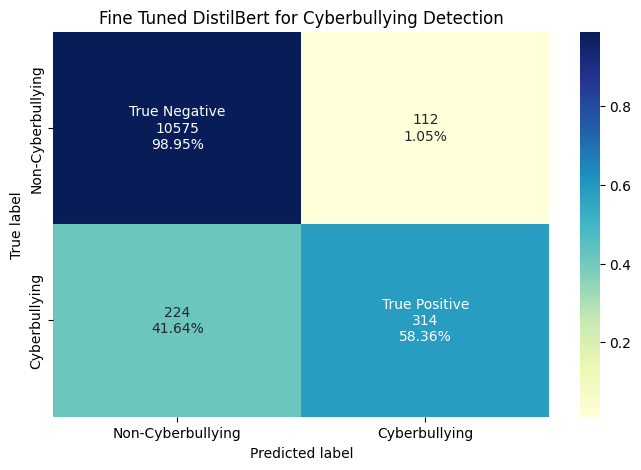

In [ ]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='/content/content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-37884',
                        average_method='binary',
                        X_test=X_test)

#### Epoch 4

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10687
           1       0.74      0.60      0.66       538

    accuracy                           0.97     11225
   macro avg       0.86      0.79      0.82     11225
weighted avg       0.97      0.97      0.97     11225


Label 1: Cyberbullying
Precision:  0.7413394919168591
Recall:  0.5966542750929368
F-measure:  0.6611740473738414

Label 0: Non-Cyberbullying
Precision:  0.9798925129725723
Recall:  0.9895199775428091
F-measure:  0.9846827133479212

Macro Metrics
Precision:  0.8606160024447157
Recall:  0.7930871263178729
F-measure:  0.8229283803608813



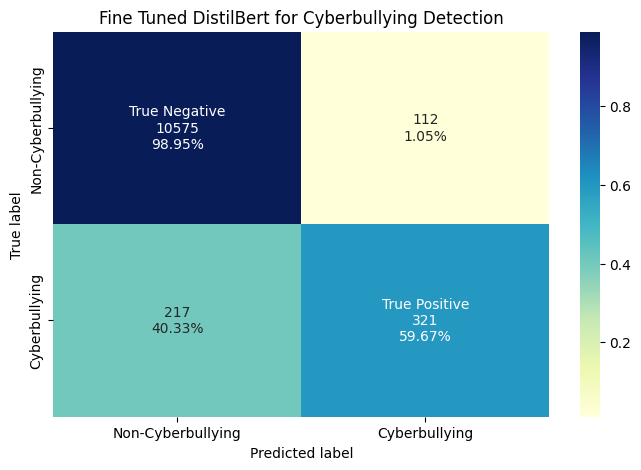

In [ ]:
compute_metrics_holdout(model_name='DistilBert',
                        model_path='/content/content/drive/MyDrive_binary/output_DistilBert/holdout/checkpoint-50512',
                        average_method='binary',
                        X_test=X_test)